<a href="https://colab.research.google.com/github/wacosta86/talento_tech_data_analyst_integrator/blob/main/Data_Analysis_using_SQL_(Change_SQL_code_for_Pandas_functions).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F63%2F589%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240410%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240410T001736Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D071cbdb3ef19c294efce1b38fa121fce500eaf2817d9bb5b243e95cb6dadee754c60ccff0dc811988720229af150082ed154de36f59bd96f8254881089e949ac59e75f5dffca477427c443297df04a9ee14bb854647e4b8f0f29cbfbad8122d5d3bcdb1789cb29ff9df8f92df01f2562c6c3d500f88d32b7ea3c1c44156d10195814790a0f4b25c5ab46ec66fcc8977c73dc4e299f1b62a531642a49e8b291a9e174f05e3acbea95a389707eb1b2b57e823414168be13fb2321f1a29daa4959de81cbf684adba3e9089d1bcbc7b33460dfa3ecc3581a06c871c1ee213c3556ddfb0c32dd1019622604c57de562255ac0427a303f3aa87ed7af84887737a4a3a8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34297253 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


# Motivation
I'll use this script to provide introduction to data analysis using SQL language, which should be a must tool for every data scientist - both for getting access to data, but more interesting, as a simple tool for advance data analysis.
The logic behind SQL is very similar to any other tool or language that used for data analysis (excel, Pandas),  and for those that used to work with data, should be very intuitive.

# Important Definitions
SQL is a conceptual language for working with data stored in databases. In our case, SQLite is the specific implementation. Most SQL languges share all of the capabilities in this doc. The differences are usually in performance and advances analytical funcionalities (and pricing of course).
Eventually, we will use SQL lunguage to write queries that would pull data from the DB, manipulate it, sort it, and extract it.

The most important component of the DB  is its tables - that's where all the data stored. Usually the data would be devided to many tables, and not stored all in one place (so designing the data stracture properly is very important). Most of this script would handle how to work with tables.
Other than tables, there are some other very useful concepts/features that we won't cover here:
* table creation
* inserting / updating data in the DB
* functions - gets a value as an input, and returns manipulation of that value (for example function that remove white spaces)

In [2]:
#Improts

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

path = "../input/"  #Insert path here
database = path + 'database.sqlite'

# First we will create the connection to the DB, and see what tables we have
The basic structure of the query is very simple:
You define what you want to see after the SELECT, * means all possible columns
You choose the table after the FROM
You add the conditions for the data you want to use from the table(s) after the WHERE

The stracture, and the order of the sections matter, while spaces, new lines, capital words and indentation are there to make the code easier to read.

In [38]:
# Connect to the SQLite database
conn = sqlite3.connect(database)

# Read the tables available in the database into a pandas DataFrame
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

# Display the available tables
print(tables)

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


# List of countries
This is the most basic query.
The only must parts of a qeury is the SELECT and the FROM (assuming you want to pull from a table)

In [6]:
# Read data from the 'Country' table into a pandas DataFrame
countries = pd.read_sql_query('SELECT * FROM Country', conn)

# Display the data from the 'Country' table
print(countries)

       id         name
0       1      Belgium
1    1729      England
2    4769       France
3    7809      Germany
4   10257        Italy
5   13274  Netherlands
6   15722       Poland
7   17642     Portugal
8   19694     Scotland
9   21518        Spain
10  24558  Switzerland


# List of leagues and their country
JOIN is used when you want to connect two tables to each other. It works when you have a common key in each of them.
Understanding the concept of Keys is crucial for connecting (joining) between data set (tables).
A key is uniquely identifies each record (row) in a table.
It can consinst of one value (cell) - usually ID, or from a combination of values that are unique in the table.

When joinin between different tables, you must:
* Decide what type of join to use. The most common are:
* * (INNER) JOIN - keep only records that match the condition (after the ON) in both the tables, and records in both tables that do not match wouldn't appear in the output
* * LEFT JOIN - keep all the values from the first (left) table - in conjunction with the matching rows from the right table. The columns from the right table, that don't have matching value in the left, would have NULL values.
* Specify the common value that is used to connect the tables (the ID of the country in that case).
* Make sure that at least one of the values has to be a key in its table. In our case, it's the Country.id. The League.country_id is not unique, as there can be more than one league in the same country

JOINs, and using them incorrectly, is the most common and dangerious mistake when writing complicated queries

In [40]:
# Read the 'League' and 'Country' tables from the SQLite database into DataFrames
League = pd.read_sql_query("SELECT * FROM League;", conn)
Country = pd.read_sql_query("SELECT * FROM Country;", conn)

# Merge the 'League' and 'Country' tables on the 'country_id' column
leagues = pd.merge(League, Country, left_on='country_id', right_on='id', suffixes=('', '_country'))

# Display the data
print(leagues)

       id  country_id                      name  id_country name_country
0       1           1    Belgium Jupiler League           1      Belgium
1    1729        1729    England Premier League        1729      England
2    4769        4769            France Ligue 1        4769       France
3    7809        7809     Germany 1. Bundesliga        7809      Germany
4   10257       10257             Italy Serie A       10257        Italy
5   13274       13274    Netherlands Eredivisie       13274  Netherlands
6   15722       15722        Poland Ekstraklasa       15722       Poland
7   17642       17642  Portugal Liga ZON Sagres       17642     Portugal
8   19694       19694   Scotland Premier League       19694     Scotland
9   21518       21518           Spain LIGA BBVA       21518        Spain
10  24558       24558  Switzerland Super League       24558  Switzerland


# List of teams
ORDER BY defines the sorting of the output - ascending or descending (DESC)

LIMIT, limits the number of rows in the output - after the sorting

In [42]:
# Read the 'Team' table from the SQLite database into a DataFrame
Team = pd.read_sql_query("SELECT * FROM Team;", conn)

# Sort the 'Team' DataFrame by 'team_long_name' and select the first 10 rows
teams = Team.sort_values(by='team_long_name').head(10)

# Display the 'teams' DataFrame
print(teams)

        id  team_api_id  team_fifa_api_id        team_long_name  \
115  16848         8350              29.0  1. FC Kaiserslautern   
101  15624         8722              31.0            1. FC Köln   
113  16239         8165             171.0        1. FC Nürnberg   
114  16243         9905             169.0       1. FSV Mainz 05   
84   11817         8576             614.0            AC Ajaccio   
82   11074       108893          111989.0      AC Arles-Avignon   
285  49116         6493            1714.0         AC Bellinzona   
169  26560        10217             650.0          ADO Den Haag   
59    9537         8583              57.0            AJ Auxerre   
69    9547         9829              69.0             AS Monaco   

    team_short_name  
115             KAI  
101             FCK  
113             NUR  
114             MAI  
84              AJA  
82              ARL  
285             BEL  
169             HAA  
59              AUX  
69              MON  


# List of matches
In this exapmle we will show only the columns that interests us, so instead of * we will use the exact names.

Some of the cells have the same name (Country.name,League.name). We will rename them using AS.

As you can see, this query has much more joins. The reasons is because the DB is designed in a star
structure - one table (Match) with all the "performance" and metrics, but only keys and IDs,
while all the descriptive information stored in other tables (Country, League, Team)

Note that Team is joined twice. This is a tricky one, as while we are using the same table name, we basically bring two different copies (and rename them using AS). The reason is that we need to bring information about two different values (home_team_api_id, away_team_api_id), and if we join them to the same table, it would mean that they are equal to each other.

You will also note that the Team tables are joined using left join. The reason is that I would prefer to keep the matches in the output - even if one of the teams is missing from the Team table for some reason.

ORDER defines the order of the output, and comes before the LIMIT and after the WHERE

In [60]:
# Merge the 'Match', 'Country', 'League', and 'Team' DataFrames
merged_matches = pd.merge(Match, Country, left_on='country_id', right_on='id', suffixes=('', '_country'))
merged_matches = pd.merge(merged_matches, League, left_on='league_id', right_on='id', suffixes=('', '_league'))
merged_matches = pd.merge(merged_matches, Team, left_on='home_team_api_id', right_on='team_api_id', suffixes=('', '_home'))
merged_matches = pd.merge(merged_matches, Team, left_on='away_team_api_id', right_on='team_api_id', suffixes=('', '_away'))

# Filter the merged DataFrame to include only matches played in Spain
matches_spain = merged_matches[merged_matches['country_id'] == Country[Country['name'] == 'Spain']['id'].values[0]]

# Sort the DataFrame by the date of the match
matches_spain_sorted = matches_spain.sort_values(by='date')

# Select the first 10 matches
detailed_matches = matches_spain_sorted.head(10)

# Display the 'detailed_matches' DataFrame
print(detailed_matches)

          id  country_id  league_id     season  stage                 date  \
21517  21518       21518      21518  2008/2009      1  2008-08-30 00:00:00   
22505  21525       21518      21518  2008/2009      1  2008-08-30 00:00:00   
23165  21520       21518      21518  2008/2009      1  2008-08-31 00:00:00   
23019  21521       21518      21518  2008/2009      1  2008-08-31 00:00:00   
22113  21519       21518      21518  2008/2009      1  2008-08-31 00:00:00   
22385  21527       21518      21518  2008/2009      1  2008-08-31 00:00:00   
22868  21522       21518      21518  2008/2009      1  2008-08-31 00:00:00   
22266  21526       21518      21518  2008/2009      1  2008-08-31 00:00:00   
22606  21523       21518      21518  2008/2009      1  2008-08-31 00:00:00   
22568  21524       21518      21518  2008/2009      1  2008-08-31 00:00:00   

       match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
21517        530023             10267              8661      

# Let's do some basic analytics
Here we are starting to look at the data at more aggregated level. Instead of looking on the raw data we will start to grouping it to different levels we want to examine.
In this example, we will base it on the previous query, remove the match and date information, and look at it at the country-league-season level.

The functionality we will use for that is GROUP BY, that comes between the WHERE and ORDER

Once you chose what level you want to analyse, we can devide the SELECT statement to two:
* Dimensions - those are the values we describing, same that we will group by later.
* Metrics - all the metrics have to be aggregated using functions.
The common functions are: sum(), count(), count(distinct ...), avg(), min(), max()

Note - it is very important to use the same dimensions both in the SELECT, and in the GROUP BY. Otherwise the output might be wrong.

Another functionality that can be used after grouping, is HAVING. This adds another layer of filtering the data, this time the output of the table **after** the grouping. A lot of times it is used to clean the output.


In [83]:
# Merge the 'Match', 'Country', 'League', and 'Team' DataFrames
merged_matches = pd.merge(Match, Country, left_on='country_id', right_on='id', suffixes=('', '_country'))
merged_matches = pd.merge(merged_matches, League, left_on='league_id', right_on='id', suffixes=('', '_league'))
merged_matches = pd.merge(merged_matches, Team, left_on='home_team_api_id', right_on='team_api_id', suffixes=('', '_home'))
merged_matches = pd.merge(merged_matches, Team, left_on='away_team_api_id', right_on='team_api_id', suffixes=('', '_away'))

# Filter the merged DataFrame to include only matches played in the selected countries
selected_countries = ['Spain', 'Germany', 'France', 'Italy', 'England']
matches_selected_countries = merged_matches[merged_matches['country_id'].isin(selected_countries)]

# Group the data by country, league, and season, then calculate various statistics
leagues_by_season = matches_selected_countries.groupby(['country_id', 'name_league', 'season']).agg(
    number_of_stages=('stage', 'nunique'),
    number_of_teams=('team_long_name_home', 'nunique'),
    avg_home_team_goals=('home_team_goal', 'mean'),
    avg_away_team_goals=('away_team_goal', 'mean'),
    avg_goal_diff=('home_team_goal - away_team_goal', 'mean'),
    avg_goals=('home_team_goal + away_team_goal', 'mean'),
    total_goals=('home_team_goal + away_team_goal', 'sum')
).reset_index()

# Filter out seasons with less than 10 stages
leagues_by_season = leagues_by_season[leagues_by_season['number_of_stages'] > 10]

# Sort the DataFrame
leagues_by_season = leagues_by_season.sort_values(by=['country_name', 'name_league', 'season'], ascending=[True, True, False])

# Display the 'leagues_by_season' DataFrame
print(leagues_by_season)

KeyError: "Column(s) ['home_team_goal + away_team_goal', 'home_team_goal - away_team_goal', 'team_long_name_home'] do not exist"

<Axes: title={'center': 'Average Goals per Game Over Time'}>

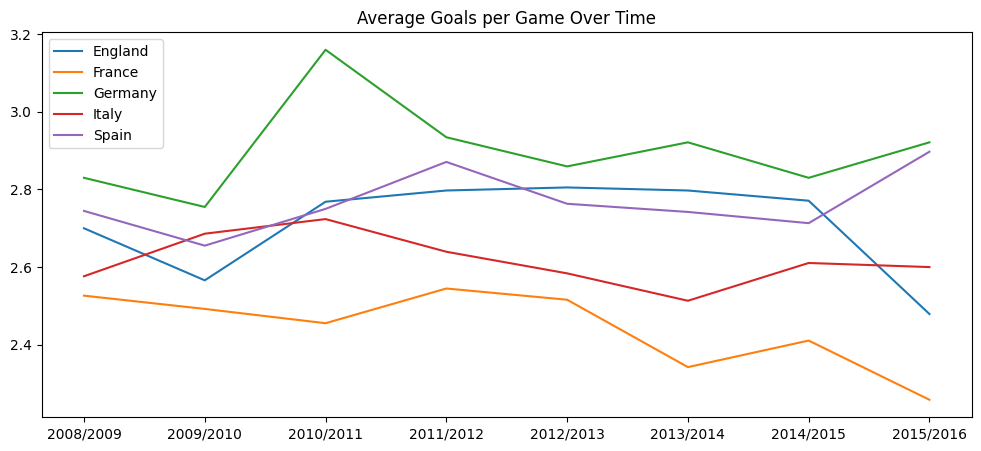

In [17]:
# Create a DataFrame with seasons as the index and countries as columns
df = pd.DataFrame(index=np.sort(leagues_by_season['season'].unique()), columns=leagues_by_season['country_name'].unique())

# Fill the DataFrame with average goals per game for each season and country
for country in df.columns:
    df.loc[:, country] = leagues_by_season.loc[leagues_by_season['country_name'] == country, 'avg_goals'].values

# Plot the DataFrame
df.plot(figsize=(12,5), title='Average Goals per Game Over Time')

<Axes: title={'center': 'Average Goal Difference Home vs Away Over Time'}>

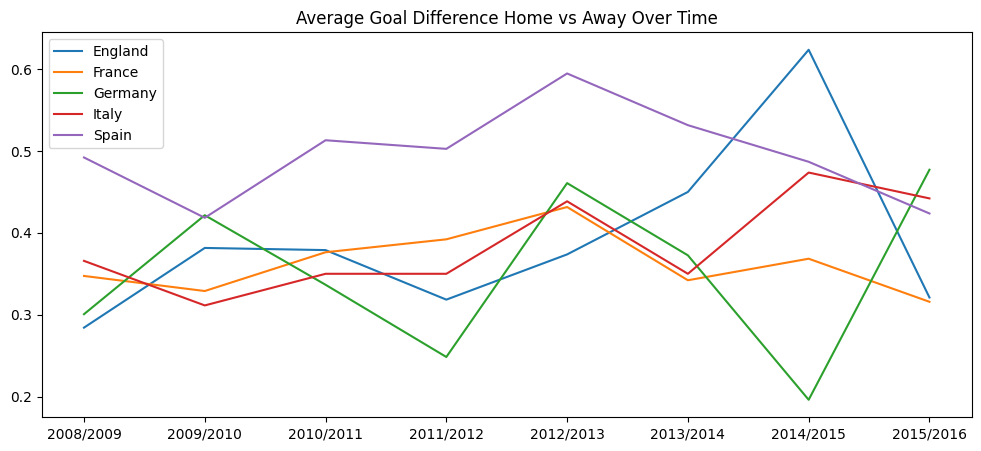

In [19]:
# Create a DataFrame with seasons as the index and countries as columns
df = pd.DataFrame(index=np.sort(leagues_by_season['season'].unique()), columns=leagues_by_season['country_name'].unique())

# Fill the DataFrame with average goal difference (home goals minus away goals) for each season and country
for country in df.columns:
    df.loc[:, country] = leagues_by_season.loc[leagues_by_season['country_name'] == country, 'avg_goal_diff'].values

# Plot the DataFrame
df.plot(figsize=(12,5), title='Average Goal Difference Home vs Away Over Time')

# Query Run Order
Now that we are familiar with most of the functionalities being used in a query, it is very important to understand the order that code runs.

As we mentioned, here is the order as it would appear in the code:
* SELECT
* FROM
* JOIN
* WHERE
* GROUP BY
* HAVING
* ORDER BY
* LIMIT

You can think of it as a two part process:
First, create a new temporal table in the memory:
* Define which tables to use, and connect them (FROM + JOIN)
* Keep only the rows that apply to the conditions (WHERE)
* Group the data by the required level (if need) (GROUP BY)
* Choose what information you want to have in the new table. It can have just rawdata (if no grouping), or combination of dimensions (from the grouping), and metrics
Then, choose what to show from the table:
* Order the output of the new table (ORDER BY)
* Add more conditions that would filter the new created table (HAVING)
* Limit to number of rows - would cut it according the soring and the having filtering (LIMIT)


# Sub Queries and Functions

Using subqueries is an essential tool in SQL, as it allows manipulating the data in very advanced ways without the need of any external scripts, and especially important when your tables stractured in such a way that you can't be joined directly.

In our example, I'm trying to join between a table that holds players' basic details (name, height, weight), to a table that holds more attributes. The problem is that while the first table holds one row for each player, the key in the second table is player+season, so if we do a regular join, the result would be a cartesian product, and each player's basic details would appear as many times as this player appears in the attributes table. The result would be that the average would be skewed towards players that appear many times in the attribute table.

The solution, is to use a subquery.  We would need to group the attributes table, to a different key - player level only (without season). Of course we would need to decide first how we would want to combine all the attributes to a single row. I used average, but one can also decide on maximum, latest season and etc.
Once both tables have the same keys, we can join them together (think of the subquery as any other table, only temporal), knowing that we won't have duplicated rows after the join.

In addition, you can see here two examples of how to use functions:
* Conditional function is an important tool for data manipulation. While IF statement is very popular in other languages, SQLite is not supporting it, and it's implemented using CASE + WHEN + ELSE statement.
As you can see, based on the input of the data, the query would return different results.

* ROUND - straight sorward.
Every SQL languages comes with a lot of usefull functions by default.

In [25]:
# Load and define DataFrames 'PLAYER' and 'PA_Grouped'
PLAYER = pd.read_sql("SELECT * FROM PLAYER;", conn)
PA_Grouped = pd.read_sql("SELECT player_api_id, avg(overall_rating) AS avg_overall_rating, avg(potential) AS avg_potential FROM Player_Attributes GROUP BY player_api_id;", conn)

# Define a function to categorize heights into ranges
def categorize_height(height):
    if height < 165:
        return 165
    elif height > 195:
        return 195
    else:
        return round(height)

# Apply the categorize_height function to create a new column 'calc_height' in the 'PLAYER' DataFrame
PLAYER['calc_height'] = PLAYER['height'].apply(categorize_height)

# Merge the 'PLAYER' DataFrame with aggregated player attributes using player_api_id
merged_df = pd.merge(PLAYER, PA_Grouped, on='player_api_id', how='left')

# Group the merged DataFrame by 'calc_height' and calculate the required statistics
players_height = merged_df.groupby('calc_height').agg({
    'height': 'count',
    'avg_overall_rating': 'mean',
    'avg_potential': 'mean',
    'weight': 'mean'
}).rename(columns={'height': 'distribution'}).reset_index()

# Order the DataFrame by 'calc_height'
players_height = players_height.sort_values('calc_height')

# Display the 'players_height' DataFrame
print(players_height)

    calc_height  distribution  avg_overall_rating  avg_potential      weight
0           165            74           67.365543      73.327754  139.459459
1           168           118           67.500518      73.124182  144.127119
2           170           403           67.726903      73.379056  147.799007
3           173           530           66.980272      72.848746  152.824528
4           175          1188           66.805204      72.258774  156.111953
5           178          1489           66.367212      71.943339  160.665547
6           180          1388           66.419053      71.846394  165.261527
7           183          1954           66.634380      71.754555  170.167861
8           185          1278           66.928964      71.833475  174.636933
9           188          1305           67.094253      72.151949  179.278161
10          190           652           66.997649      71.846159  184.791411
11          193           470           67.485141      72.459225  188.795745

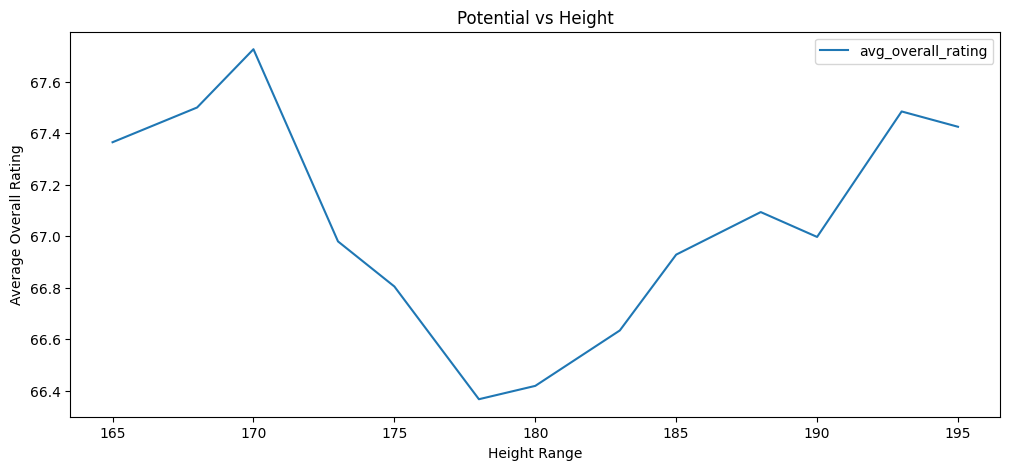

In [27]:
# Plot the average overall rating against the height ranges
players_height.plot(x='calc_height', y='avg_overall_rating', figsize=(12, 5), title='Potential vs Height')
plt.xlabel('Height Range')
plt.ylabel('Average Overall Rating')
plt.show()